In [132]:
import os
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import (
    mean_absolute_error,
    mean_absolute_percentage_error,
    mean_squared_error,
    accuracy_score,
)

ROOT_DIR = str(Path(os.getcwd()).parent.parent.absolute())
sys.path.append(os.path.join(ROOT_DIR, "code"))
from tools.utils import load_json
from tools.utils import custom_mape, percentile_absolute_percentage_error

In [9]:
DATA_DIR = os.path.join(ROOT_DIR, "data")
OPTIM_RES_DIR = os.path.join(DATA_DIR, "test_optimization_results")

In [25]:
OPT_RES = load_json(os.path.join(OPTIM_RES_DIR, "optimization_results.json"))
SIM_RES = load_json(os.path.join(OPTIM_RES_DIR, "data_opt_par.json"))
REF_ENERGY = pd.read_csv(os.path.join(DATA_DIR, "ref_energy.csv"))

In [65]:
opt_res_params = [{**x, **x["params"]} for x in OPT_RES]
opt_res_df = pd.DataFrame(opt_res_params)
opt_res_df.drop(["params"], axis=1, inplace=True)
opt_res_df

,structure,max_delta_E,sim_time_pred,delta_E_pred,ecutrho,k_density,ecutwfc
0,Sr1N1,0.100000,164.261369,5.153436e-03,155,3,28
1,Sr1N1,0.010000,164.261369,5.096845e-03,194,3,29
2,Sr1N1,0.001000,628.133645,4.795131e-04,118,3,40
3,Sr1N1,0.000100,653.979647,5.632547e-05,140,3,42
4,Sr1N1,0.000010,141153.570920,2.658487e-06,233,10,98
...,...,...,...,...,...,...,...
595,Nd1Hg1,0.010000,66503.839130,8.414595e-04,348,5,37
596,Nd1Hg1,0.001000,66503.839130,8.414595e-04,348,5,37
597,Nd1Hg1,0.000100,75848.830435,3.594837e-06,105,4,75
598,Nd1Hg1,0.000010,928638.691304,4.498947e-08,362,9,33


In [64]:
sim_res_df = pd.DataFrame(SIM_RES)
sim_res_df.rename(columns={"system": "structure", "time": "sim_time_real"}, inplace=True)
sim_res_df["k_density"] = sim_res_df["k_density"].apply(lambda x: int(round(1/x)))
sim_res_df = pd.merge(sim_res_df, REF_ENERGY, on="structure")
sim_res_df["delta_E_real"] = np.abs(sim_res_df["total_energy_x"] - sim_res_df["total_energy_y"])
sim_res_df.drop(["total_energy_x", "total_energy_y", "accuracy", "fermi", "n_iterations"], axis=1, inplace=True)
sim_res_df

,ecutrho,k_density,ecutwfc,sim_time_real,converged,structure,delta_E_real
0,304,10,100,223097.0,True,Ag1Ir1,3.100000e-07
1,112,5,37,22155.0,True,Ag1Ir1,1.476869e-02
2,193,5,42,22071.0,True,Ag1Ir1,3.441175e-03
3,168,6,47,37143.0,True,Ag1Ir1,3.941000e-05
4,186,10,98,220110.0,True,Ag1Ir1,1.692500e-05
...,...,...,...,...,...,...,...
553,182,3,25,2116.0,True,Zr1S1,7.583555e-03
554,264,5,26,12070.0,True,Zr1S1,9.647700e-04
555,152,10,38,112068.0,True,Zr1S1,1.016750e-04
556,108,10,58,114105.0,True,Zr1S1,1.806500e-05


In [83]:
def count_not_unique(l):
    visited = set()
    count = 0
    for x in l:
        key = repr(x)
        if key not in visited:
            visited.add(key)
        else:
            count += 1
    return count

col_keys = ["structure", "k_density", "ecutrho", "ecutwfc"]

print(f"Number of duplicated keys in opt_res_df: {count_not_unique(opt_res_df[col_keys].values)}")
print(f"Number of duplicated keys in sim_res_df: {count_not_unique(sim_res_df[col_keys].values)}")

Number of dupliacted keys in opt_res_df: 15
Number of dupliacted keys in sim_res_df: 0


There are duplicated keys in opt_res_df since the optimization procedure generated the same parameters for different max_delta_E values.

In [84]:
full_df = pd.merge(sim_res_df, opt_res_df, on=col_keys)
full_df

,ecutrho,k_density,ecutwfc,sim_time_real,converged,structure,delta_E_real,max_delta_E,sim_time_pred,delta_E_pred
0,304,10,100,223097.0,True,Ag1Ir1,3.100000e-07,0.000001,209556.320200,4.788765e-07
1,112,5,37,22155.0,True,Ag1Ir1,1.476869e-02,0.100000,9917.615330,2.041514e-02
2,193,5,42,22071.0,True,Ag1Ir1,3.441175e-03,0.010000,10393.127872,1.456631e-03
3,168,6,47,37143.0,True,Ag1Ir1,3.941000e-05,0.001000,36115.138752,3.642626e-04
4,186,10,98,220110.0,True,Ag1Ir1,1.692500e-05,0.000010,204997.406497,4.450958e-06
...,...,...,...,...,...,...,...,...,...,...
568,182,3,25,2116.0,True,Zr1S1,7.583555e-03,0.100000,1005.701372,1.557236e-02
569,264,5,26,12070.0,True,Zr1S1,9.647700e-04,0.010000,8440.464447,1.986217e-04
570,152,10,38,112068.0,True,Zr1S1,1.016750e-04,0.000100,168006.602029,8.888457e-05
571,108,10,58,114105.0,True,Zr1S1,1.806500e-05,0.000010,184814.058297,6.680331e-06


## Check max_delta_E constraint

In [98]:
# count max_delta_E respected
print(f"Expected: {100*(full_df['max_delta_E'] >= full_df['delta_E_pred']).sum()/full_df.shape[0]:.2f}% of simulations have max_delta_E respected")
print(f"Result: {100*(full_df['max_delta_E'] >= full_df['delta_E_real']).sum()/full_df.shape[0]:.2f}% of simulations have max_delta_E respected")

Expected: 93.37% of simulations have max_delta_E respected
Result: 56.72% of simulations have max_delta_E respected


In [147]:
idx_prob = full_df['max_delta_E'] < full_df['delta_E_real']
ratio_prob = full_df[idx_prob]['delta_E_real'] / full_df[idx_prob]['max_delta_E']
ratio = full_df['delta_E_real'] / full_df['max_delta_E']

In [148]:
ratio.describe()

count      573.000000
mean        86.800832
std        930.580722
min          0.000415
25%          0.316414
50%          0.813587
75%          3.005000
max      19483.190000
dtype: float64

In [149]:
np.log10(ratio).describe()

count    573.000000
mean       0.052017
std        1.009984
min       -3.381952
25%       -0.499744
50%       -0.089596
75%        0.477844
max        4.289660
dtype: float64

In [150]:
ratio_prob.describe()

count      248.000000
mean       200.018264
std       1408.097095
min          1.010000
25%          1.686888
50%          4.362045
75%         18.739662
max      19483.190000
dtype: float64

In [151]:
np.log10(ratio_prob).describe()

count    248.000000
mean       0.890807
std        0.859735
min        0.004321
25%        0.227079
50%        0.639690
75%        1.272753
max        4.289660
dtype: float64

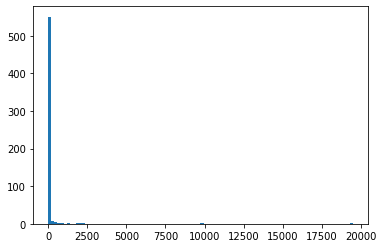

In [152]:
plt.hist(ratio, bins=100)
plt.show()

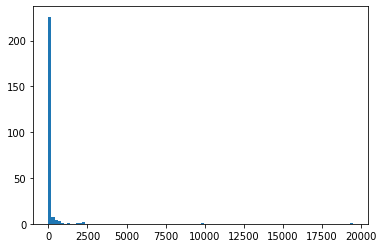

In [153]:
plt.hist(ratio_prob, bins=100)
plt.show()

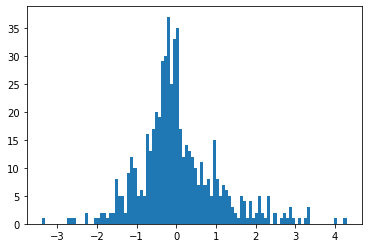

In [154]:
plt.hist(np.log10(ratio), bins=100)
plt.show()

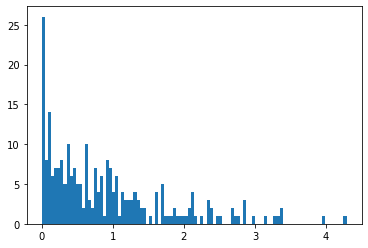

In [155]:
plt.hist(np.log10(ratio_prob), bins=100)
plt.show()

## Check delta_E_pred vs delta_E_real

In [156]:
losses = [
    ("MSE", mean_squared_error),
    ("MAE", mean_absolute_error),
    ("MAPE", mean_absolute_percentage_error),
    ("Custom MAPE", lambda a, b: custom_mape(a, b, True)),
    (
        "50%-APE",
        lambda a, b: percentile_absolute_percentage_error(
            a, b, 50
        ),
    ),
    (
        "90%-APE",
        lambda a, b: percentile_absolute_percentage_error(
            a, b, 90
        ),
    ),
]

In [157]:
print("delta_E_pred vs delta_E_real")
for loss_name, loss_fn in losses:
    print(f"{loss_name} loss: {loss_fn(full_df['delta_E_real'], full_df['delta_E_pred']):.4E}")

delta_E_pred vs delta_E_real
MSE loss: 1.8805E-04
MAE loss: 5.0747E-03
MAPE loss: 6.0169E+00
Custom MAPE loss: 7.1804E+00
50%-APE loss: 7.0862E-01
90%-APE loss: 1.9087E+00


In [160]:
print("log10_delta_E_pred vs log10_delta_E_real")
for loss_name, loss_fn in losses:
    print(f"{loss_name} loss: {loss_fn(np.log10(full_df['delta_E_real']), np.log10(full_df['delta_E_pred'])):.4E}")

log10_delta_E_pred vs log10_delta_E_real
MSE loss: 1.0864E+00
MAE loss: 6.8014E-01
MAPE loss: 2.4055E-01
Custom MAPE loss: 3.3749E-01
50%-APE loss: 1.2188E-01
90%-APE loss: 5.7902E-01


## Check sim_time_pred vs sim_time_real

In [159]:
print("sime_time_pred vs sim_time_real")
for loss_name, loss_fn in losses:
    print(f"{loss_name} loss: {loss_fn(full_df['sim_time_real'], full_df['sim_time_pred']):.4E}")

sime_time_pred vs sim_time_real
MSE loss: 3.2334E+09
MAE loss: 2.4901E+04
MAPE loss: 3.9318E-01
Custom MAPE loss: 7.6035E-01
50%-APE loss: 2.8405E-01
90%-APE loss: 7.0172E-01


In [161]:
print("log10_sime_time_pred vs log10_sim_time_real")
for loss_name, loss_fn in losses:
    print(f"{loss_name} loss: {loss_fn(np.log10(full_df['sim_time_real']), np.log10(full_df['sim_time_pred'])):.4E}")

log10_sime_time_pred vs log10_sim_time_real
MSE loss: 9.9684E-02
MAE loss: 2.0941E-01
MAPE loss: 5.3847E-02
Custom MAPE loss: 2.2309E-01
50%-APE loss: 2.8062E-02
90%-APE loss: 1.3560E-01
